In [8]:
#HW4
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import scipy as sp
import time
import os

In [9]:
#Global - based on given diagrams in the assignment where y direction is up
iVec = np.array([1, 0, 0])
jVec = np.array([0, 1, 0])
kVec = np.array([0, 0, 1])

flatPlateProjectedArea = 1.0
sphereProjectedArea = np.pi
apolloProjectedArea = (1.9558 ** 2) * np.pi

In [10]:
def loadMeshData(filename):
    meshIn = np.loadtxt(filename)

    if filename == 'Apollo_Processed.dat':
        meshIn[:, 0] = -meshIn[:, 0] #compensate for Apollo mesh x direction being flipped

    numNodes = meshIn.shape[0]
    nodesPerTriangle = 3
    numCoordinates = meshIn.shape[1]  # I hope it is 3 unless we got 4 in space

    nodeCheck1 = numNodes % 3
    if nodeCheck1 != 0:
        print("Error: Number of nodes is not divisible by 3, check mesh.")
        return 0
    elif nodeCheck1 == 0:
        print("Number of nodes is divisible by 3, mesh is good to go.")

    numTriangleElements = numNodes / 3
    # print(f"Number of triangles = {numTriangleElements}")
    # print(f"Number of nodes = {numNodes}")
    # print(f"Number of coordinates = {meshIn.shape[1]}")

    meshOut = meshIn.reshape(int(numTriangleElements), nodesPerTriangle, numCoordinates)  # Defining coordinates per element instead of node (numTriangleElements, nodesPerTriangle, numCoordinates)

    return meshOut, numNodes, numCoordinates, meshIn


def makeGeometry(meshIn, meshInNodes, meshInCoordinates):
    areaPerTriangleElement = np.zeros(meshIn.shape[0])
    normalToTriangleElements = np.zeros((meshIn.shape[0], 3))

    for i in range(meshIn.shape[0]):
        x1 = meshIn[i, 0, :]
        x2 = meshIn[i, 1, :]
        x3 = meshIn[i, 2, :]

        dx21 = x2 - x1
        dx31 = x3 - x1

        crossProd = np.cross(dx21, dx31)
        crossNorm = np.linalg.norm(crossProd)

        areaPerTriangleElement[i] = 0.5 * crossNorm

        if crossNorm > 1e-12:
            normalToTriangleElements[i, :] = crossProd / crossNorm
        else:
            normalToTriangleElements[i, :] = np.zeros(3)

        nodeCheck2 = 1e-12
        if areaPerTriangleElement[i] > nodeCheck2:
            zeroTriangleArea = True
        else:
            zeroTriangleArea = False

    if np.any(areaPerTriangleElement < 1e-12):
        print("Warning: At least 1 triangle area is near-zero. Check mesh.")
    else:
        print("All triangle areas are non-zero, mesh is good.")

    totalArea = np.sum(areaPerTriangleElement)
    print(f"Total Surface Area = {totalArea:.4f} m^2")  # Compare this with the actual area for sanity check 3

    return areaPerTriangleElement, normalToTriangleElements



def newtonianAerodynamicsSolver(meshIn, areaPerTriangleElement, normalToTriangleElements, aoa, areaProjected, freeStreamVelocity, liftAxis):
    # aoa = np.deg2rad(aoa)
    dragAxis = freeStreamVelocity / np.linalg.norm(freeStreamVelocity)

    cP = np.zeros(meshIn.shape[0])
    elementcL = np.zeros(meshIn.shape[0])
    elementcD = np.zeros(meshIn.shape[0])

    for i in range(meshIn.shape[0]):
        normalToTriangle = normalToTriangleElements[i, :]
        area = areaPerTriangleElement[i]

        flowExposure = np.dot(normalToTriangle, freeStreamVelocity)  # u dot n

        if flowExposure > 0:
            cP[i] = 2 * (flowExposure) ** 2
            elementcD[i] = (cP[i] * area / areaProjected) * np.dot(normalToTriangle, freeStreamVelocity)
            elementcL[i] = (cP[i] * area / areaProjected) * (np.dot(normalToTriangle, liftAxis))

        elif flowExposure < 0:
            cP[i] = 0.0

    cD = np.sum(elementcD)
    cL = np.sum(elementcL)
    cLcD = cL / cD

    print(f"Results: Cd = {cD:.4f}, Cl = {cL:.4f}, L/D = {cLcD:.4f}")

    return cP, cD, cL, cLcD


def plotting(mesh, cP, aoa, filename):

    vertsPerElement = mesh.reshape(-1, 3, 3)
    vmin = 0
    vmax = 2
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    colors = plt.cm.jet(norm(cP))

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = Poly3DCollection(vertsPerElement,
                                facecolors=colors,
                                edgecolor='gray',
                                linewidths=0.1,
                                antialiased=True)


    ax.add_collection3d(surf)


    max_range = np.array([mesh[:, 0].max() - mesh[:, 0].min(),
                          mesh[:, 1].max() - mesh[:, 1].min(),
                          mesh[:, 2].max() - mesh[:, 2].min()]).max() / 2.0

    mid_x = (mesh[:, 0].max() + mesh[:, 0].min()) * 0.5
    mid_y = (mesh[:, 1].max() + mesh[:, 1].min()) * 0.5
    mid_z = (mesh[:, 2].max() + mesh[:, 2].min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    ax.set_box_aspect([1, 1, 1])

    m = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    m.set_array([])
    plt.colorbar(m, ax=ax, label='$C_p$')


    title_name = filename.split('_')[0]
    ax.set_title(f'$C_p$ Distribution on {title_name} ($\\alpha = {np.round(np.rad2deg(aoa))}^\circ$)', fontsize=14)
    ax.set_xlabel('x (m)');
    ax.set_ylabel('y (m)');
    ax.set_zlabel('z (m)')

    plt.show()

    return 0


def solution(aoa, projectedArea, filename):
    aoa = np.deg2rad(aoa)
    liftAxis = np.array([-np.sin(aoa), np.cos(aoa), 0])
    freeStreamVelocity = np.array([np.cos(aoa), np.sin(aoa), 0])


    if filename == 'Flat_Plate_Processed.dat':
        freeStreamVelocity = np.array([np.cos(aoa), -np.sin(aoa), 0]) #normal vector for flat plate is flipped and Cp = 0 for negative u dot n so had to compensate
        liftAxis = np.array([-np.sin(aoa), -np.cos(aoa), 0]) #consequently lift axis must be compensated

    elif filename == 'Apollo_Processed.dat':
        freeStreamVelocity = np.array([-np.cos(aoa), -np.sin(aoa), 0]) #x direction is flipped with the Apollo mesh
        liftAxis = np.array([np.sin(aoa), -np.cos(aoa), 0]) #consequently lift axis must be compensated


    objectMesh, objectNodes, objectCoordinates, objectMeshIn = loadMeshData(filename)
    objectTriArea, objectTriNormal = makeGeometry(objectMesh, objectNodes, objectCoordinates)
    objectcP, objectcD, objectcL, apolloCLcD = newtonianAerodynamicsSolver(objectMesh, objectTriArea, objectTriNormal, aoa, projectedArea, freeStreamVelocity, liftAxis)
    plotting(objectMeshIn, objectcP, aoa, filename)

    return objectcP

<>:139: SyntaxWarning: invalid escape sequence '\c'
<>:139: SyntaxWarning: invalid escape sequence '\c'
C:\Users\water\AppData\Local\Temp\ipykernel_28560\282434172.py:139: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title(f'$C_p$ Distribution on {title_name} ($\\alpha = {np.round(np.rad2deg(aoa))}^\circ$)', fontsize=14)


Flat Plate Results:
-------------------
Number of nodes is divisible by 3, mesh is good to go.
All triangle areas are non-zero, mesh is good.
Total Surface Area = 1.0000 m^2
Results: Cd = 0.0000, Cl = 0.0000, L/D = nan


C:\Users\water\AppData\Local\Temp\ipykernel_28560\282434172.py:92: RuntimeWarning: invalid value encountered in scalar divide
  cLcD = cL / cD


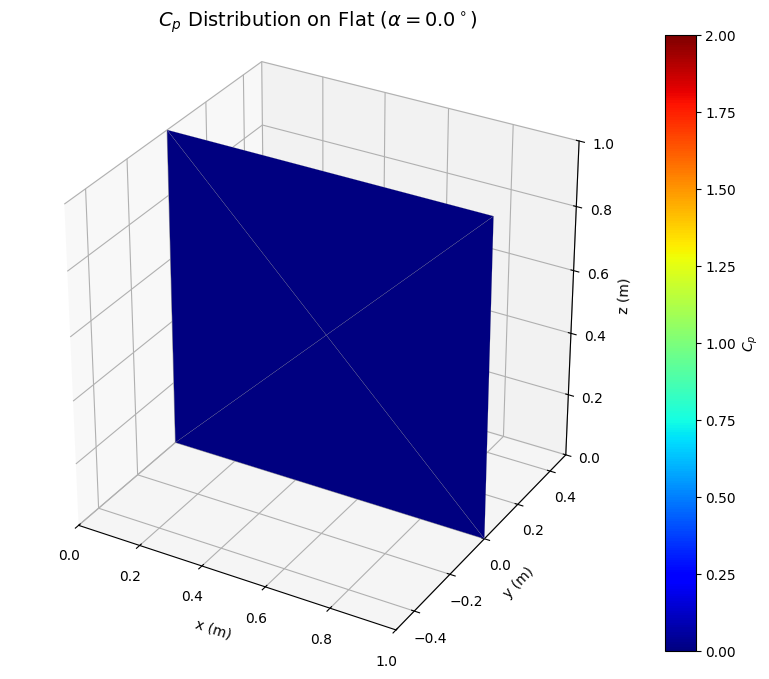

Number of nodes is divisible by 3, mesh is good to go.
All triangle areas are non-zero, mesh is good.
Total Surface Area = 1.0000 m^2
Results: Cd = 0.2500, Cl = 0.4330, L/D = 1.7321


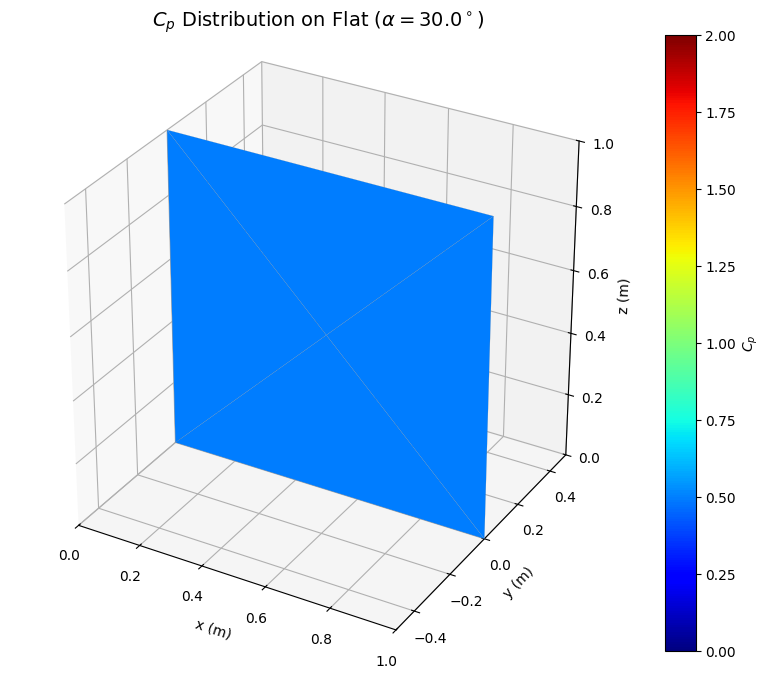

Number of nodes is divisible by 3, mesh is good to go.
All triangle areas are non-zero, mesh is good.
Total Surface Area = 1.0000 m^2
Results: Cd = 1.2990, Cl = 0.7500, L/D = 0.5774


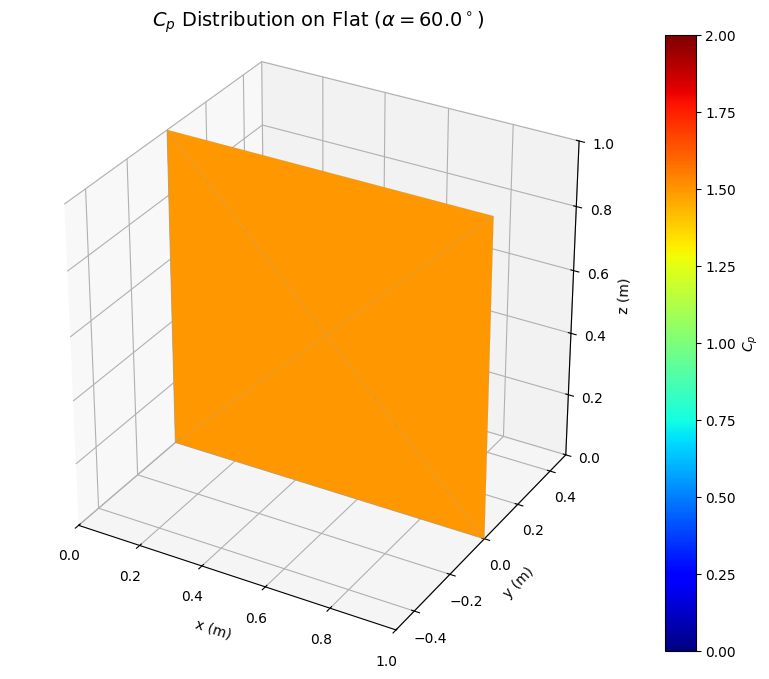


-------------------

Sphere Results:
-------------------
Number of nodes is divisible by 3, mesh is good to go.
All triangle areas are non-zero, mesh is good.
Total Surface Area = 12.5497 m^2
Results: Cd = 0.9987, Cl = 0.0000, L/D = 0.0000


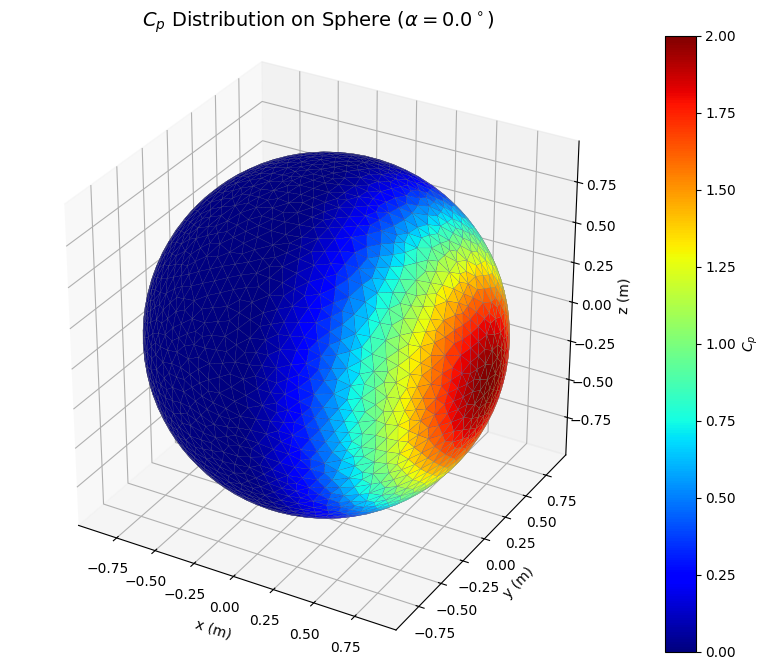

Number of nodes is divisible by 3, mesh is good to go.
All triangle areas are non-zero, mesh is good.
Total Surface Area = 12.5497 m^2
Results: Cd = 0.9987, Cl = 0.0000, L/D = 0.0000


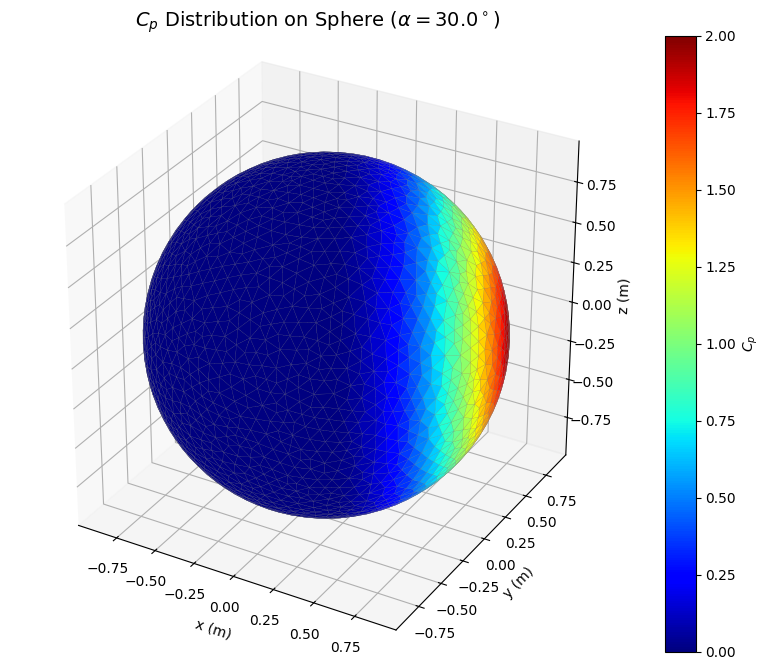

Number of nodes is divisible by 3, mesh is good to go.
All triangle areas are non-zero, mesh is good.
Total Surface Area = 12.5497 m^2
Results: Cd = 0.9987, Cl = -0.0000, L/D = -0.0000


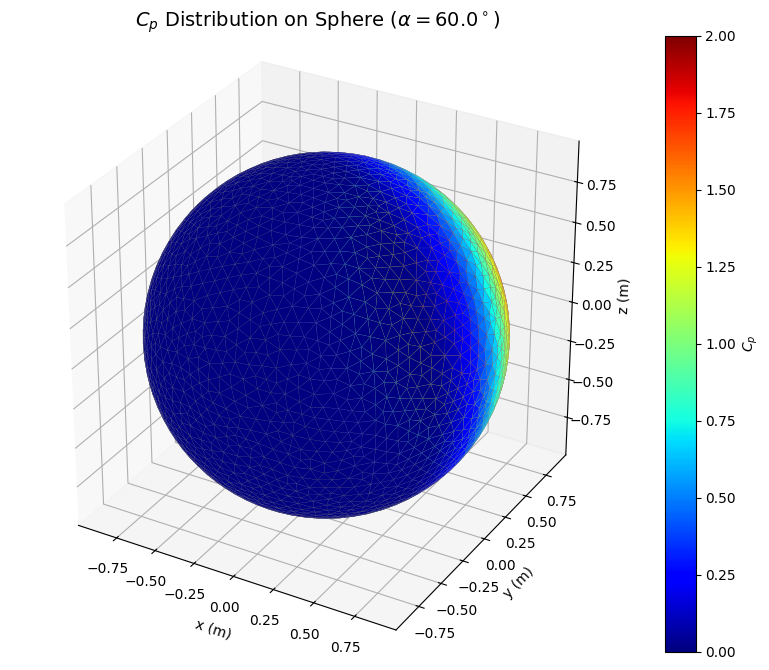


-------------------

Apollo Results:
-------------------
Number of nodes is divisible by 3, mesh is good to go.
All triangle areas are non-zero, mesh is good.
Total Surface Area = 36.4433 m^2
Results: Cd = 1.4876, Cl = 0.4510, L/D = 0.3032


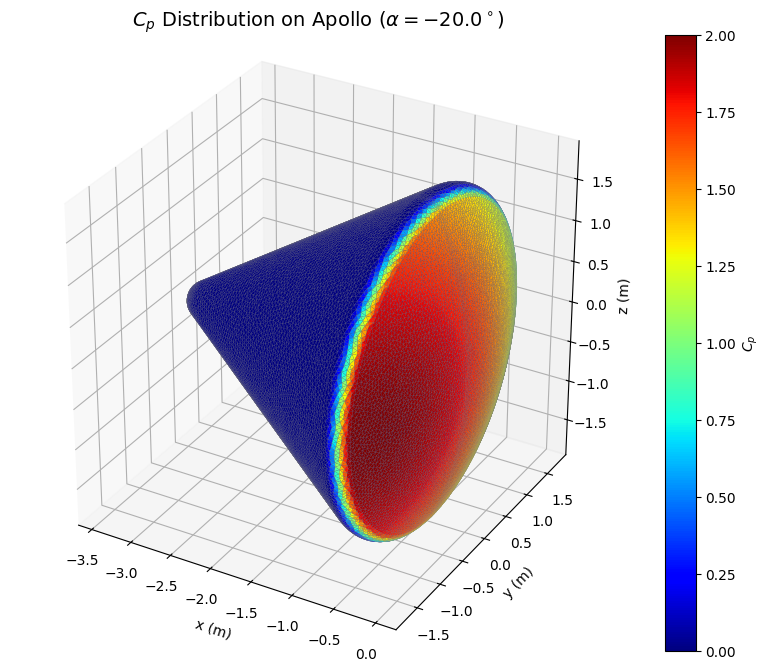

array([1.92278481, 1.92936919, 1.68901025, ..., 0.        , 0.        ,
       0.        ], shape=(32456,))

In [11]:
print("Flat Plate Results:")
print("-------------------")
solution(0, flatPlateProjectedArea, 'Flat_Plate_Processed.dat')
solution(30, flatPlateProjectedArea, 'Flat_Plate_Processed.dat')
solution(60, flatPlateProjectedArea, 'Flat_Plate_Processed.dat')
print("\n-------------------\n")

print("Sphere Results:")
print("-------------------")
solution(0, sphereProjectedArea, 'Sphere_Processed.dat')
solution(30, sphereProjectedArea, 'Sphere_Processed.dat')
solution(60, sphereProjectedArea, 'Sphere_Processed.dat')
print("\n-------------------\n")

print("Apollo Results:")
print("-------------------")
solution(-20, apolloProjectedArea, 'Apollo_Processed.dat')

#Copy and paste this code into a .py file to make plots interactive and move in 3D. Works in VSCode.